--------------------------------------------
**All information in ths notebook is licensed under the BSD 3-Clause "New" or "Revised" License. The license is found [here](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/LICENSE).**

**If any part of this notebook is used in your research, please cite with the reference found in [README.md](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/README.md#bibtex-citation).**

--------------------------------------------
# Pseudo-empirical example of non-duplicated intersects 
## Demonstrating an enhanced intersect operation with [sjoin in GeoPandas](http://geopandas.org/reference/geopandas.sjoin.html)
### Author: James D. Gaboardi jgaboardi@gmail.com
-----------------------------------
**This notebook provides a pseudo-empirical example of non-duplicated intersects. This method can be thought of as "point-associated-with-polygon," because it captures the spatial relationship of points contained within a polygon and touching the exterior of the polygon, while preserving the cardinality of the original point set, $|P| = |P^\prime|$.**

### Overview

1. **Defined functions and variables**
2. **Census Block data**
3. **Simulated point data**
4. **Demostrate `nd-intersects`: Full County, Single Membership, Multi-Membership**

In [1]:
%load_ext watermark
%watermark

2020-01-31T12:57:46-05:00

CPython 3.6.7
IPython 7.11.1

compiler   : GCC Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import nd_intersects

# imports print versions for watermark
import fiona
import geopandas
import matplotlib
from matplotlib import pyplot
import numpy
import shapely
from shapely.geometry import Point

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina", quality=100)
except ImportError:
    pass

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
geopandas     0.6.2
nd_intersects 0.0.1
matplotlib    3.1.2
numpy         1.17.5
shapely       1.7.0
fiona         1.8.13



---------------------------------------
## 1. Defined Variables and Function
#### Variables

In [3]:
gpkg = "gpkg"
driver = gpkg.upper()
ptid = "ID"
pgid = "GEOID10"

#### Simulated points function

In [4]:
def simulated_points(in_data, needed=20, seed=0, point_id=None):
    """Generate synthetic spatial data points within an area.
    
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    point_id : str
        Optional ID column. Default is None.
    
    Returns
    -------
    points : geopandas.GeoDataFrame
        Simulated points.
    """
    
    def generate_point():
        xmin, xmax, ymin, ymax = area[0], area[2], area[1], area[3]
        x = numpy.random.uniform(xmin, xmax, 1)
        y = numpy.random.uniform(ymin, ymax, 1)
        return Point(x,y)
    
    area = tuple(in_data.total_bounds)
    numpy.random.seed(seed)
    create = range(needed)
    points = [generate_point() for idx in create]
    points = geopandas.GeoDataFrame(geometry=points, crs=in_data.crs)
    
    if point_id:
        ids = [str(idx) for idx in create]
        points[point_id] = ids
    
    return points

#### Plotting utilities

In [5]:
def add_suptitle():
    pyplot.suptitle("Union County, FL", x=0.515, y=0.88, fontsize=30)

def add_title(title):
    pyplot.title(title, fontsize=20)

def pgon_labels(p):
    def _loc(_x):
        return [coord for coord in _x.geometry.centroid.coords[0]]
    kws = {"size": 15, "va": "bottom"}
    p.apply(lambda x: base.annotate(s=x[pgid], xy=_loc(x), **kws), axis=1)

def pt_labels(p):
    def _lab(_x):
        return ", ".join([_x[ptid], _x[pgid]])
    def _loc(_x):
        return _x.geometry.coords[0]
    kws = {"size": 10, "va": "bottom", "weight": "bold"}
    p.apply(lambda x: base.annotate(s=_lab(x), xy=_loc(x), **kws), axis=1)

-----------------------------------
## 2. Census block data from 2010 in Union County, FL
#### Read in block data from a `geopackage`

In [6]:
fname_in = "data/blocks_2010_12125.%s" % gpkg
layer = fiona.listlayers(fname_in)[0]
print(layer)
kwargs = {"layer":layer, "driver":driver, "index_col":0}
blocks = geopandas.read_file(fname_in, **kwargs)
blocks.head()

block2010_US


,GEOID10,geometry
0,121259602001018,"MULTIPOLYGON (((-82.37676 30.13605, -82.37787 ..."
1,121259602001127,"MULTIPOLYGON (((-82.44259 30.07703, -82.44259 ..."
2,121259602001155,"MULTIPOLYGON (((-82.33496 30.07992, -82.33516 ..."
3,121259602005019,"MULTIPOLYGON (((-82.34652 30.01242, -82.34622 ..."
4,121259602001095,"MULTIPOLYGON (((-82.46127 30.09867, -82.46207 ..."


#### Plot

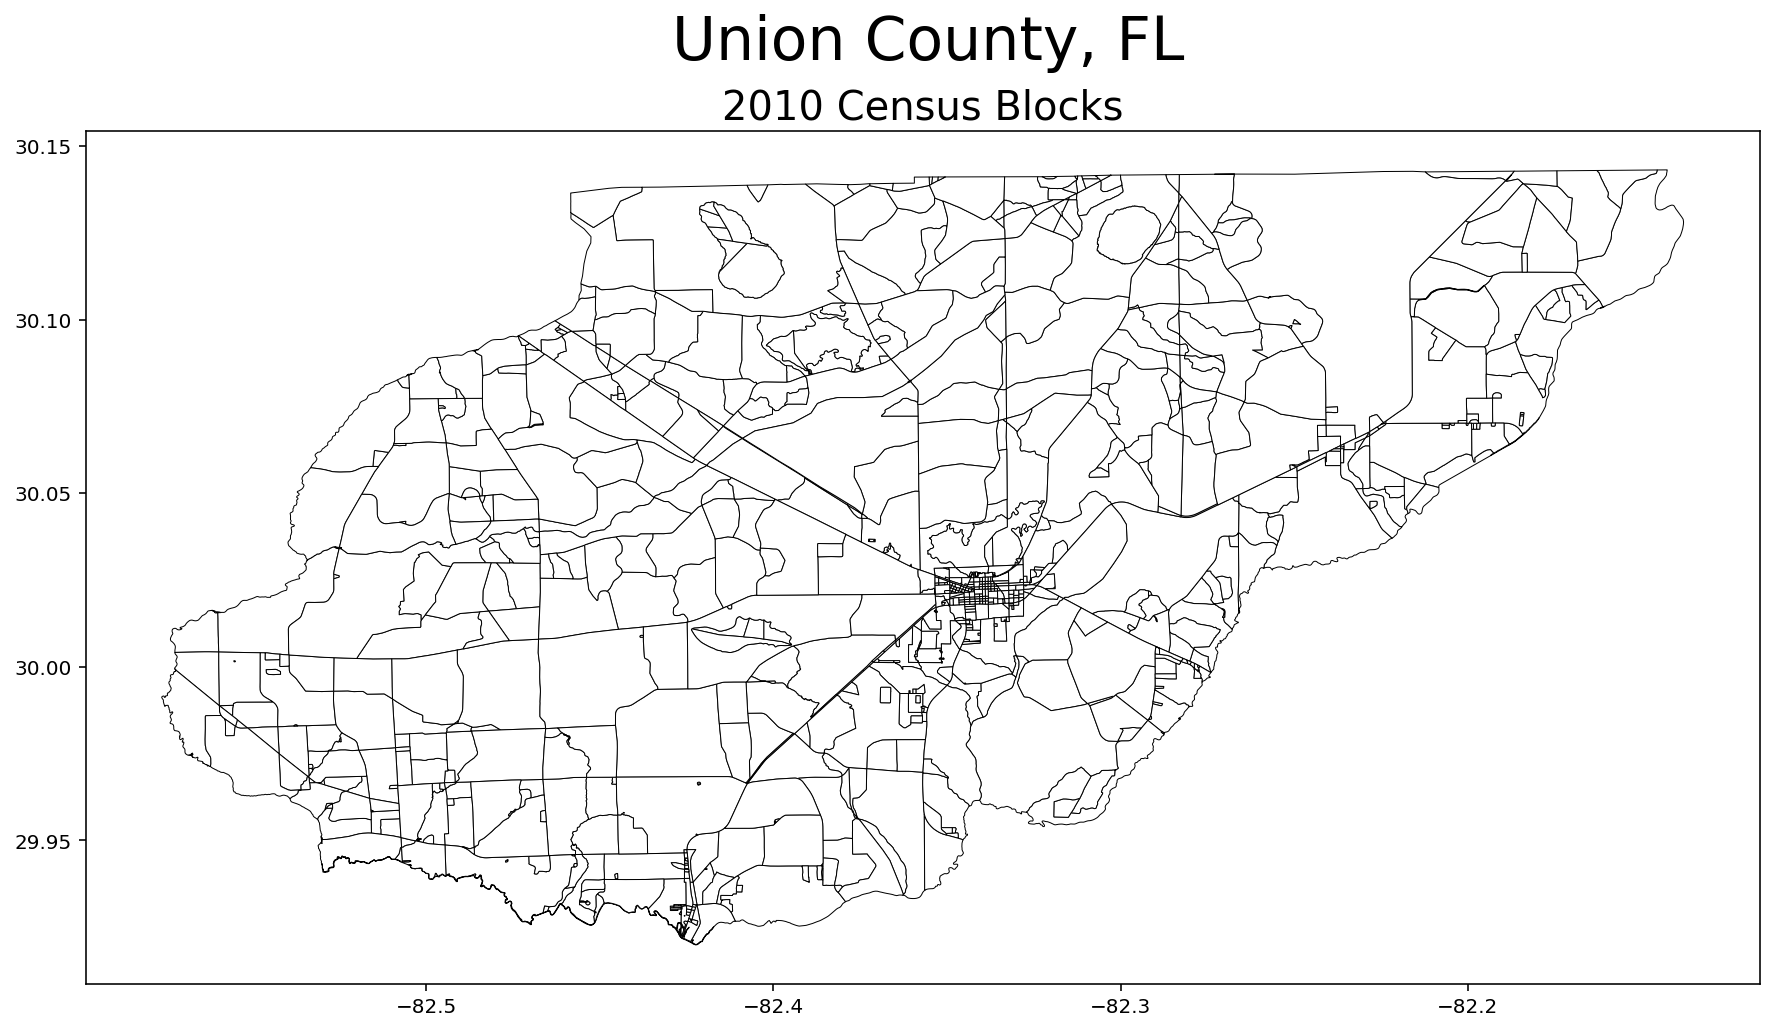

In [7]:
poly_kwargs = {"zorder":0, "facecolor":"w", "edgecolor":"k", "lw":.5}
blocks.plot(figsize=(15,10), **poly_kwargs)
add_suptitle(); add_title("2010 Census Blocks");

-----------------------------------
## 3. Simulated point data for demonstration of `nd_intersects`
#### Create simulated points within the bounding box of Union County

In [8]:
n = 20
points = simulated_points(blocks, needed=n, point_id=ptid)
points.head()

,geometry,ID
0,POINT (-82.33561 30.07955),0
1,POINT (-82.31196 30.04154),1
2,POINT (-82.39046 30.06408),2
3,POINT (-82.38436 30.11896),3
4,POINT (-82.15378 30.00550),4


#### Plot

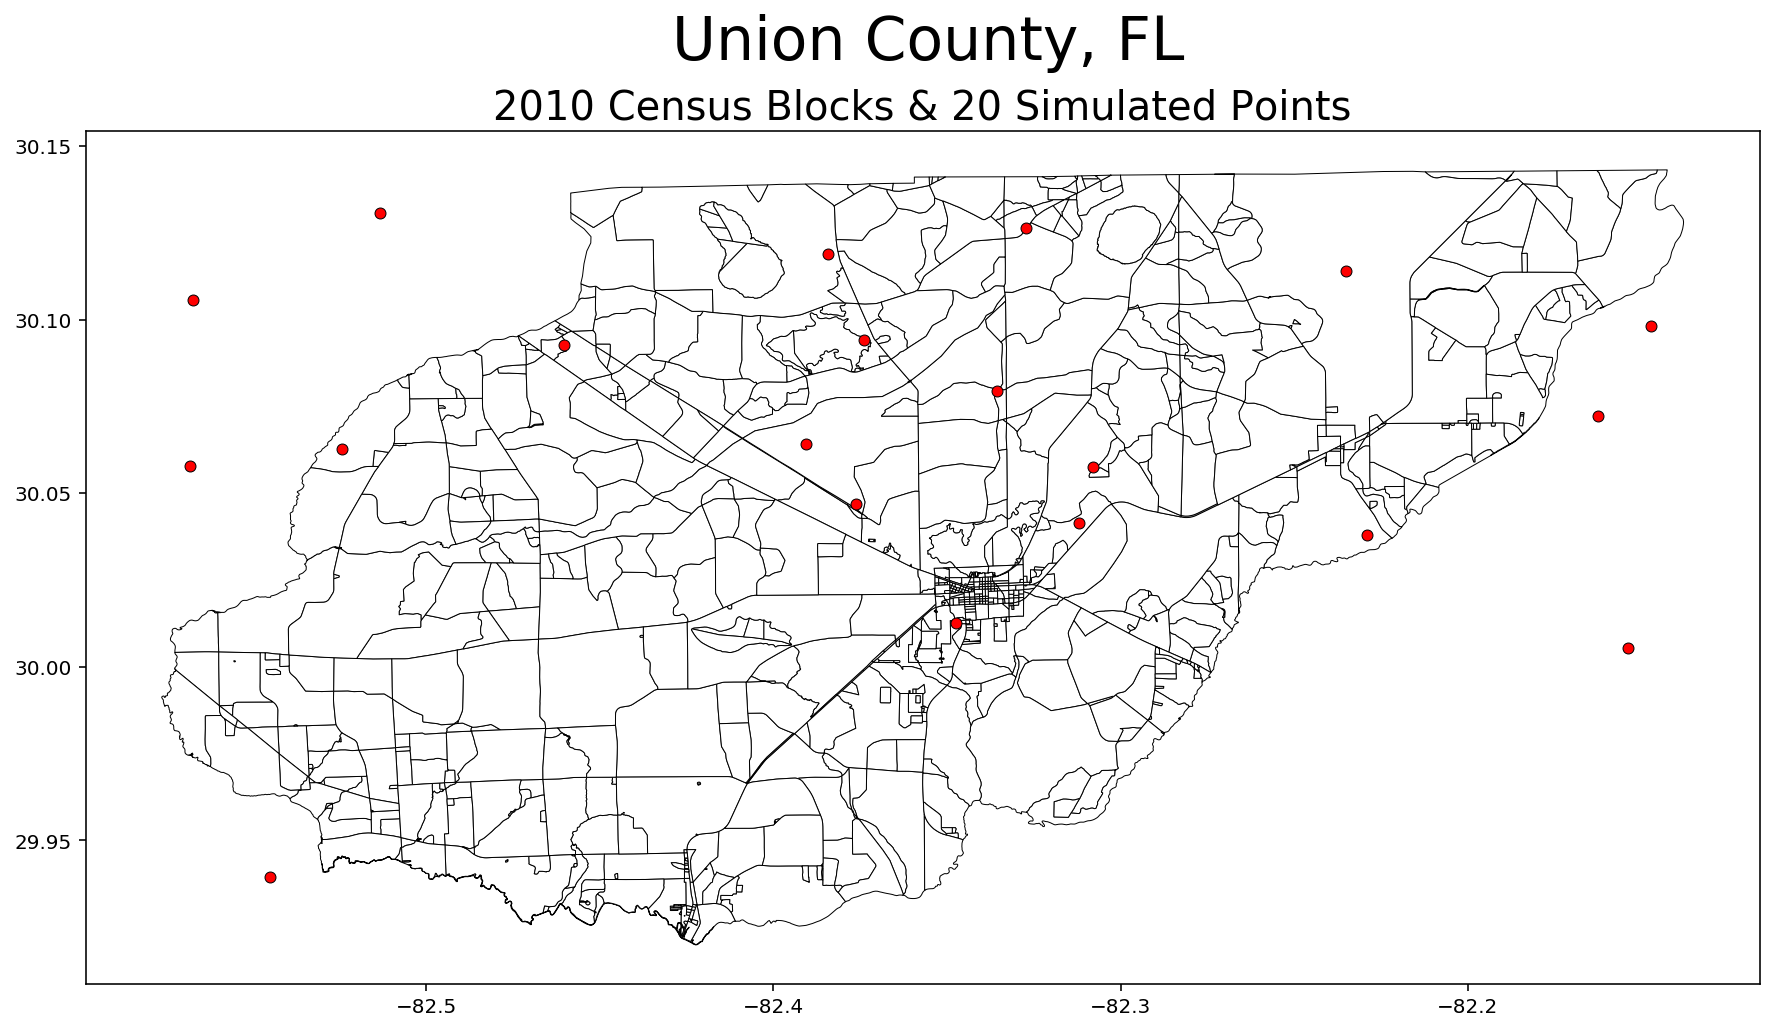

In [9]:
base = blocks.plot(figsize=(15,10), **poly_kwargs)
point_kwargs = {"zorder":1, "markersize":30, "color":"red", "ec":"k", "lw":.5}
points.plot(ax=base, **point_kwargs)
add_suptitle(); add_title("2010 Census Blocks & %s Simulated Points" % n);

-----------------------------------
## 4. Demonstrate `nd_intersects`
### 4.1 Full county
#### Perform the `nd_intersects` method

In [10]:
args = (points, blocks, ptid, pgid, [ptid, pgid])
joined = nd_intersects.nd_intersects(*args)
joined.head()

,ID,GEOID10,geometry
0,0,121259602001155,POINT (-82.33561 30.07955)
1,1,121259602003000,POINT (-82.31196 30.04154)
2,10,NaN,POINT (-82.14723 30.09829)
3,11,121259602001049,POINT (-82.37388 30.09413)
4,12,121259602001117,POINT (-82.52431 30.06275)


#### Plot — associated block color code

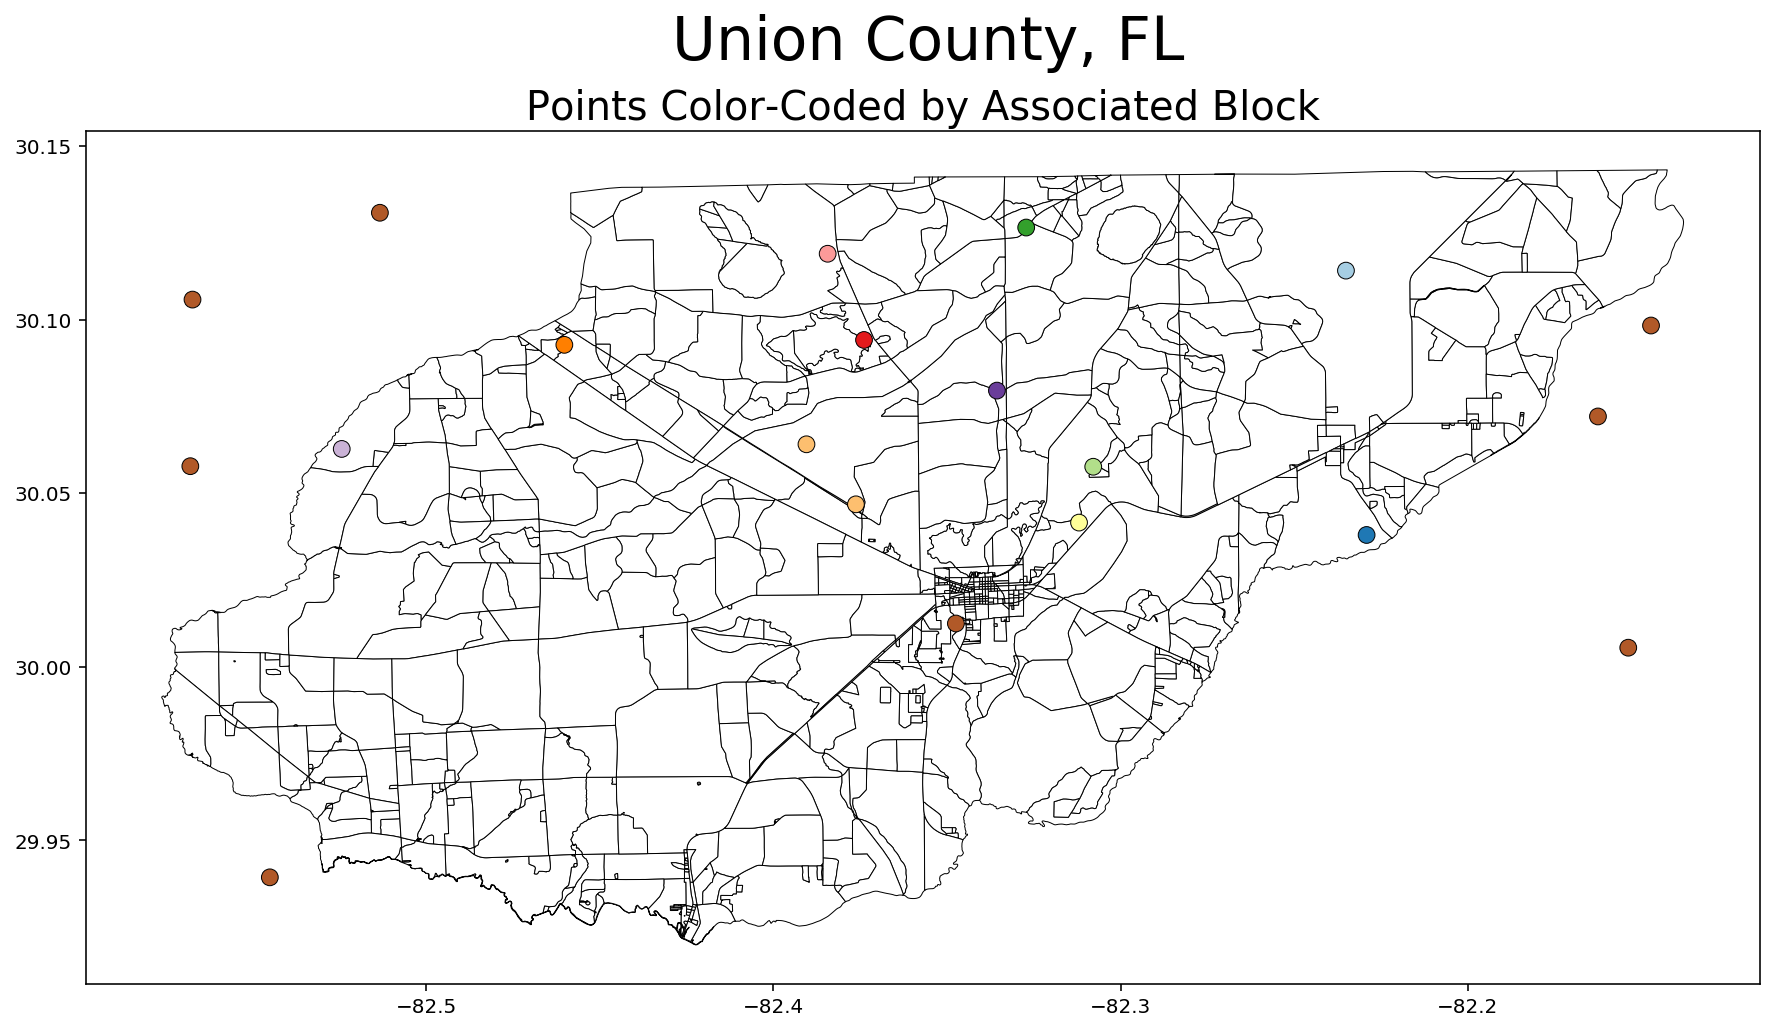

In [11]:
base = blocks.plot(figsize=(15,10), **poly_kwargs)
point_kwargs = {"zorder":1, "markersize":70, "ec":"k", "lw":.5}
join_kwargs = {"cmap":"Paired", "column":pgid}
joined.plot(ax=base, **point_kwargs, **join_kwargs)
add_suptitle();
add_title("Points Color-Coded by Associated Block");

### 4.2 Single block membership
#### Perform the `nd_intersects` method

In [12]:
geoid = "121259602001064"
single_block = blocks[blocks[pgid] == geoid]
subset_joined = joined[joined[pgid] == geoid]
subset_joined

,ID,GEOID10,geometry
8,16,121259602001064,POINT (-82.37622 30.04679)
12,2,121259602001064,POINT (-82.39046 30.06408)


#### Plot — Context

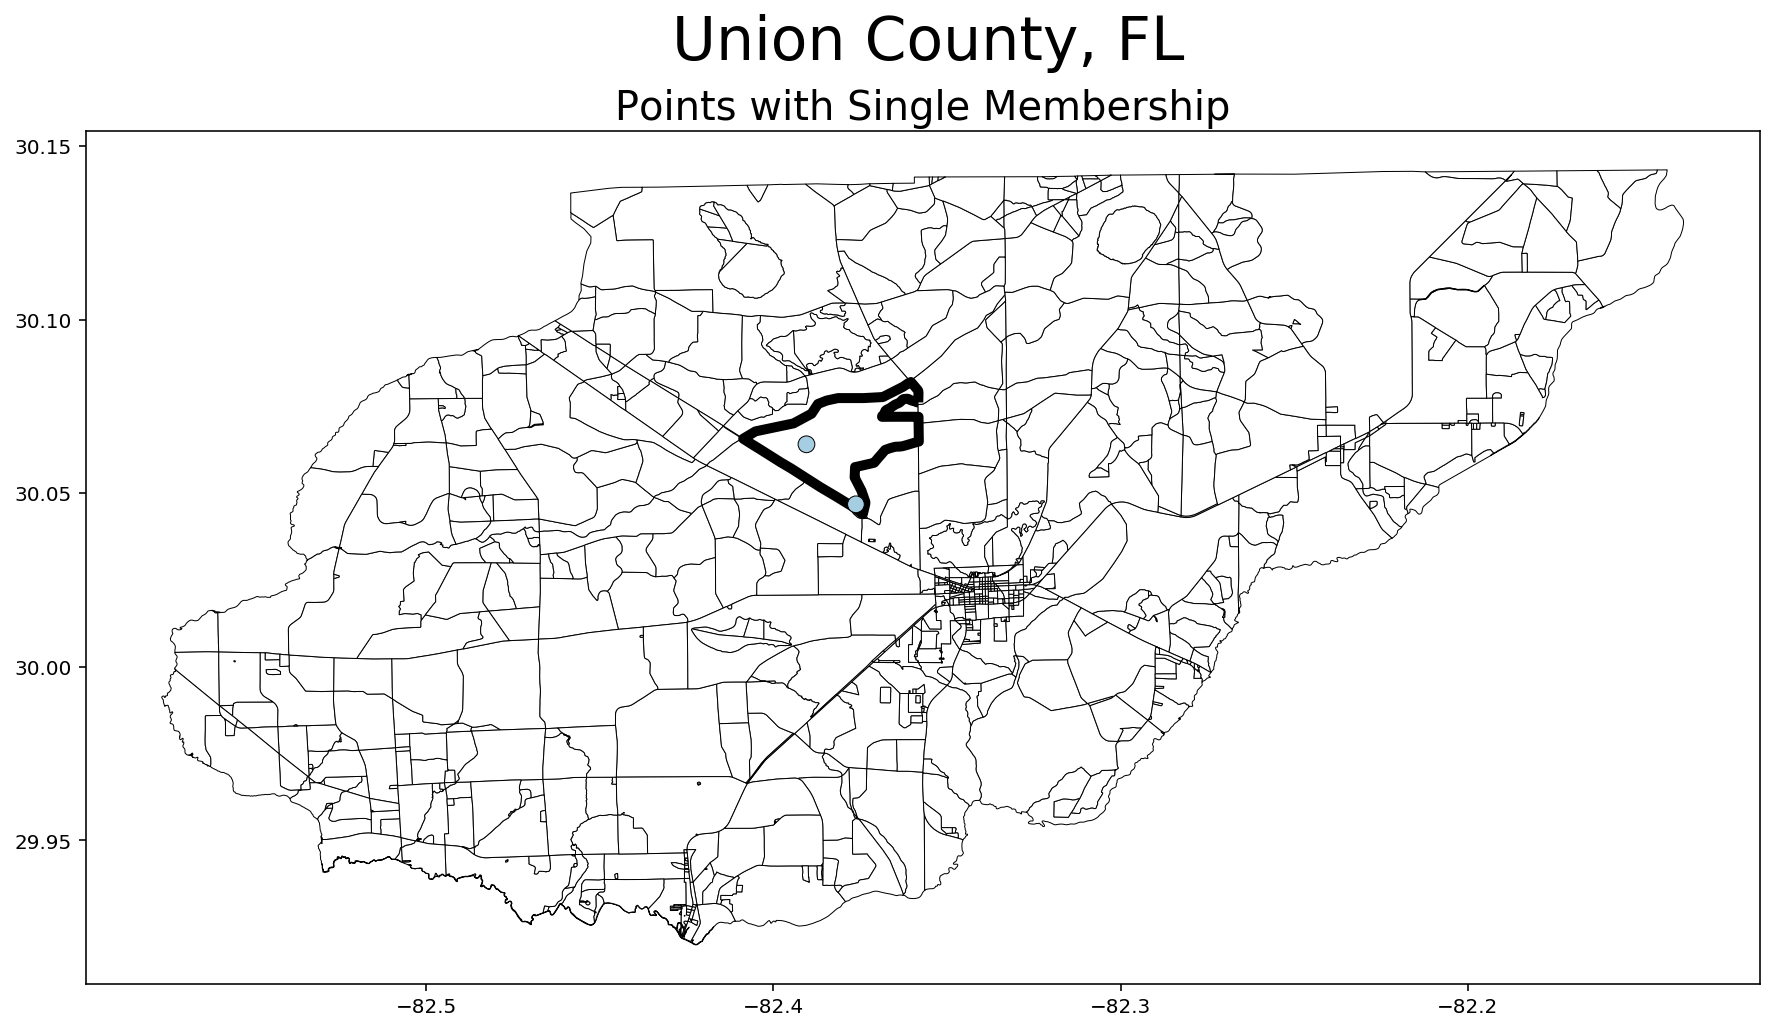

In [13]:
base = blocks.plot(figsize=(15,10), **poly_kwargs)
poly_kwargs.update({"lw":5})
single_block.plot(ax=base, **poly_kwargs)
point_kwargs = {"zorder":1, "markersize":70, "ec":"k", "lw":.5}
join_kwargs = {"cmap":"Paired", "column":pgid}
subset_joined.plot(ax=base, **point_kwargs, **join_kwargs)
add_suptitle(); add_title("Points with Single Membership");

#### Plot — Single block, Multiple points w/ matching `GEOID10`

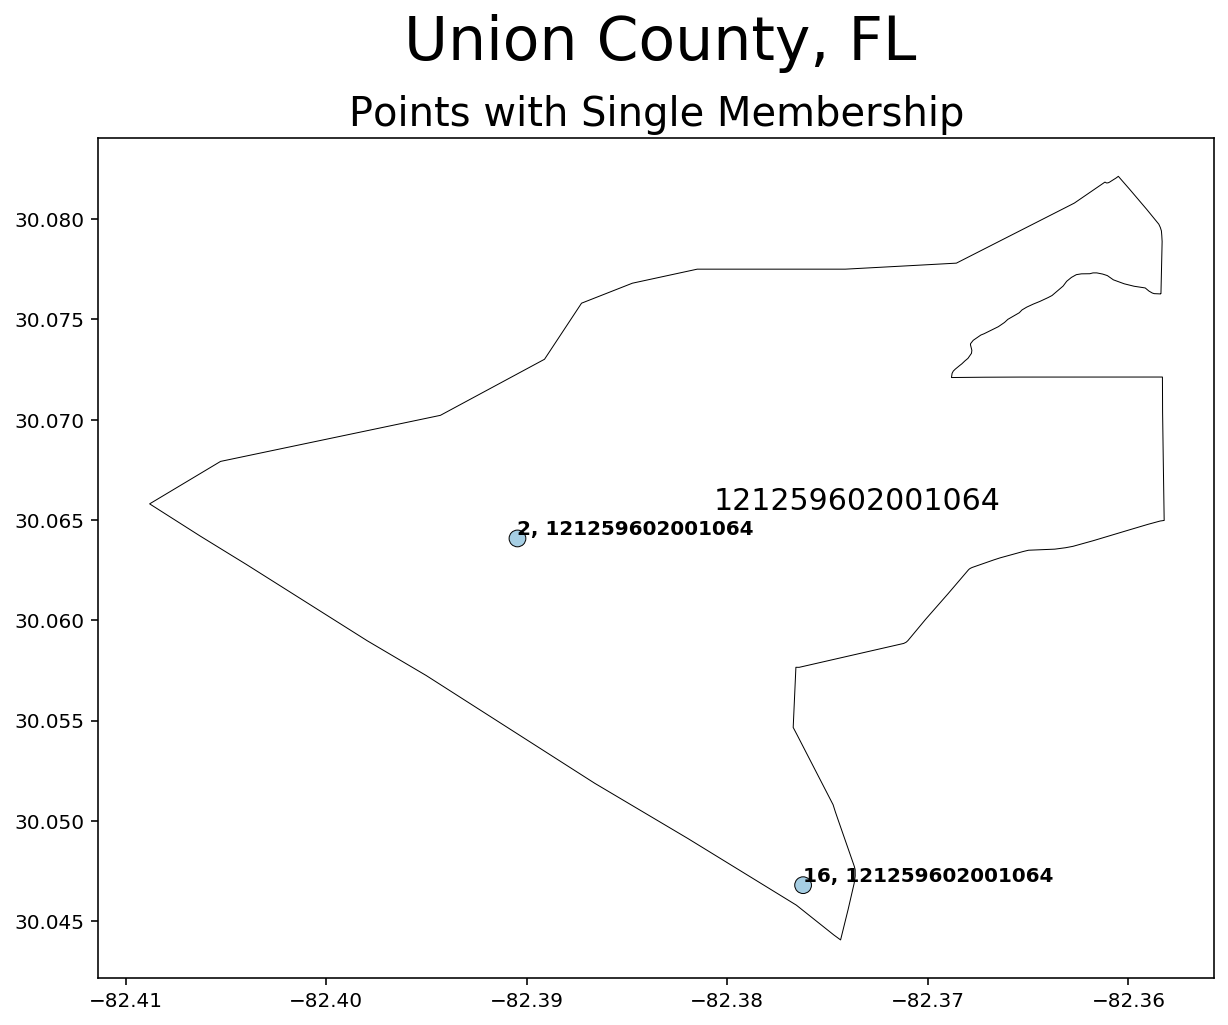

In [14]:
poly_kwargs.update({"lw":.5})
base = single_block.plot(figsize=(10,10), **poly_kwargs)
subset_joined.plot(ax=base, **point_kwargs, **join_kwargs)
pgon_labels(single_block)
pt_labels(subset_joined)
add_suptitle(); add_title("Points with Single Membership");

### 4.3 Multi-block membership (point exactly at the boundary of two blocks)
#### Perform the `nd_intersects` method

In [15]:
rook_case = ["1212596020030"+rc for rc in ["40", "42"]]
rook_blocks = blocks[blocks[pgid].isin(rook_case)]
rook_blocks

,GEOID10,geometry
515,121259602003040,"MULTIPOLYGON (((-82.33978 30.02309, -82.34068 ..."
700,121259602003042,"MULTIPOLYGON (((-82.33898 30.02241, -82.33977 ..."


#### Plot — Context (full county)

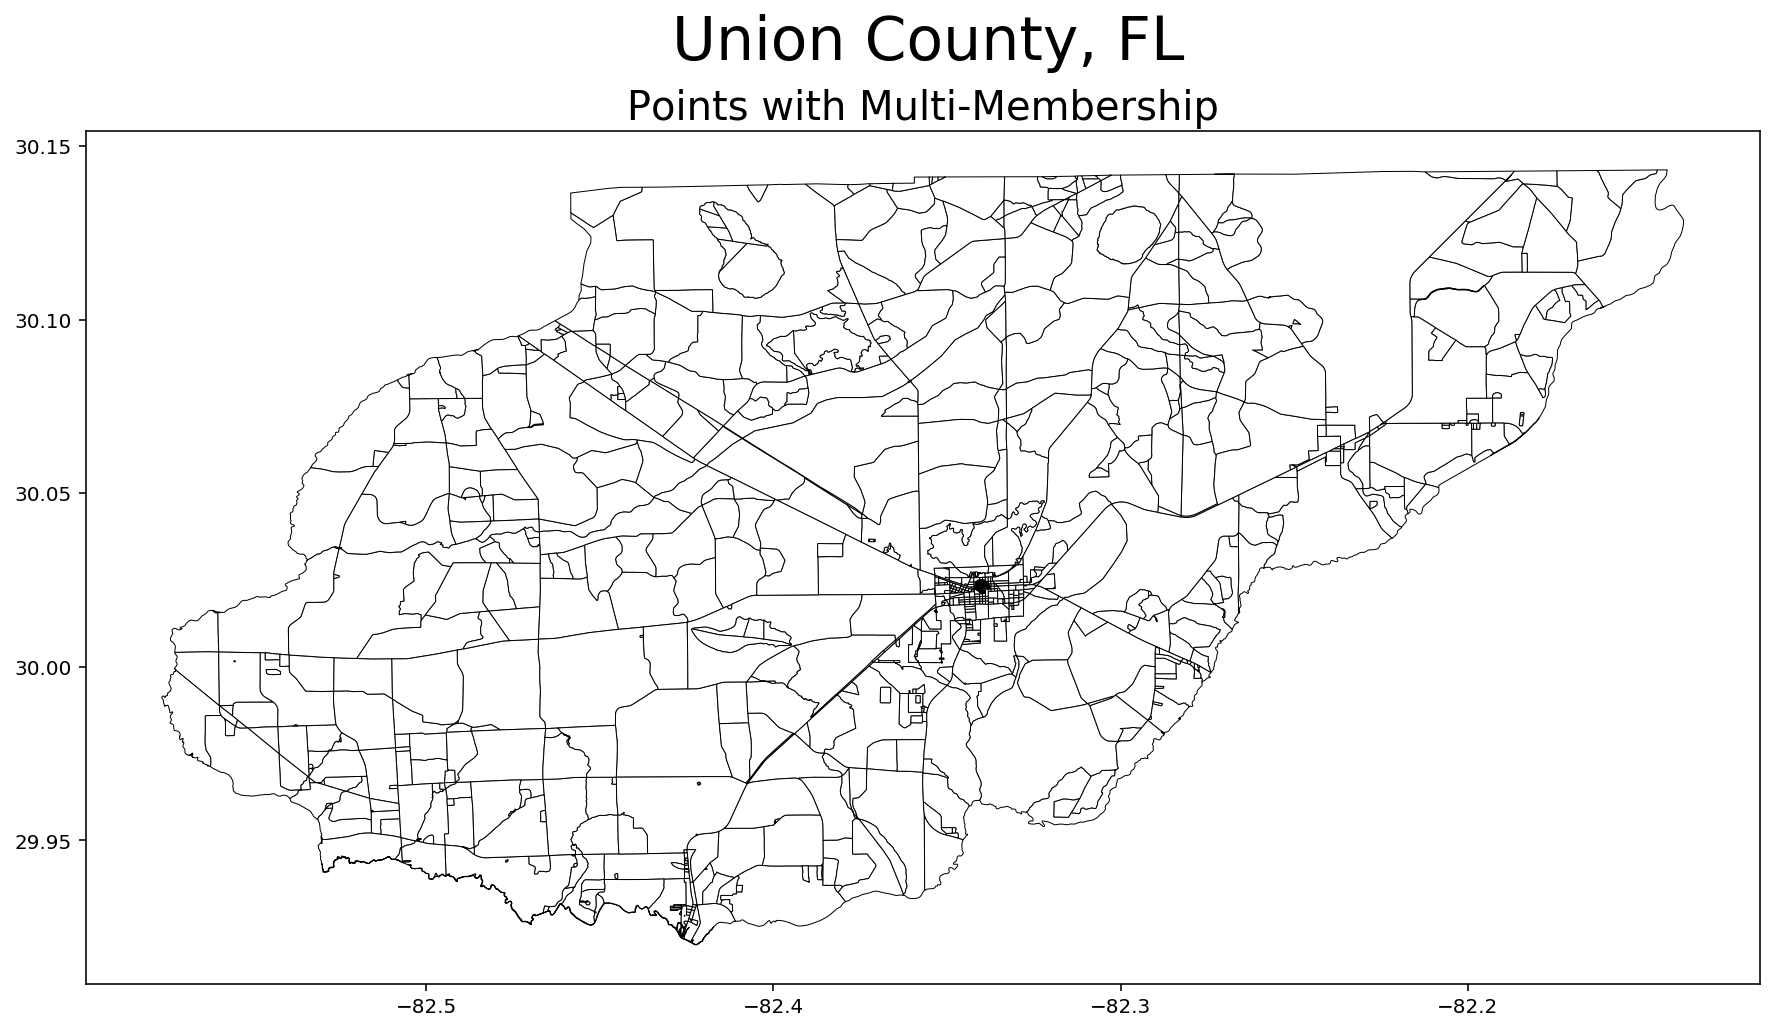

In [16]:
base = blocks.plot(figsize=(15,10), **poly_kwargs)
poly_kwargs.update({"lw":5})
rook_blocks.plot(ax=base, **poly_kwargs)
add_suptitle(); add_title("Points with Multi-Membership");

#### Plot — Context (zoomed)

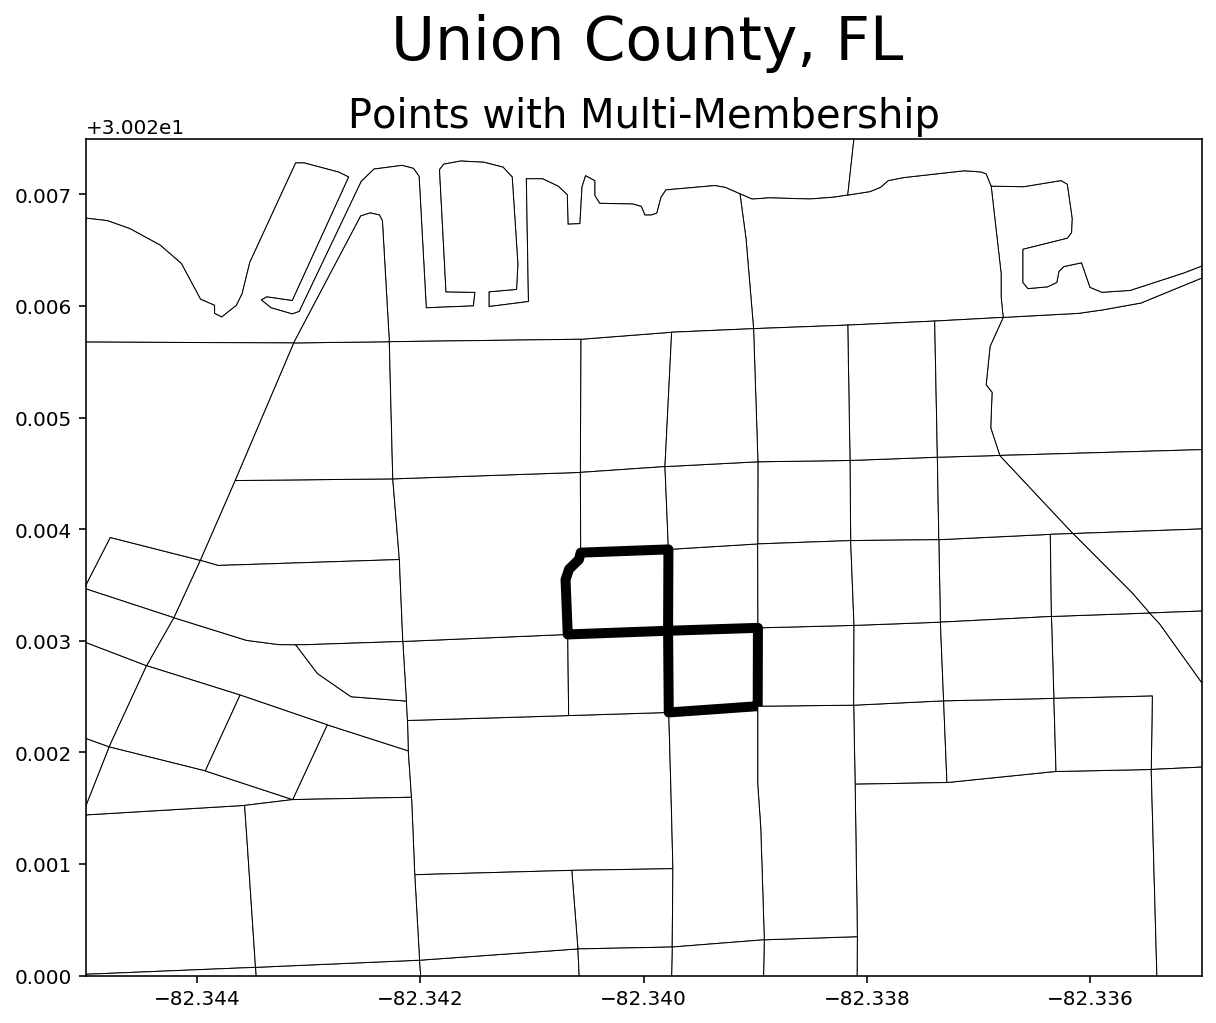

In [17]:
poly_kwargs.update({"lw":.5})
base = blocks.plot(figsize=(10,10), **poly_kwargs)
poly_kwargs.update({"lw":5})
rook_blocks.plot(ax=base, **poly_kwargs)
pyplot.xlim(-82.345, -82.335)
pyplot.ylim(30.02, 30.0275)
add_suptitle(); add_title("Points with Multi-Membership");

#### Plot — Two blocks, rook connectivity

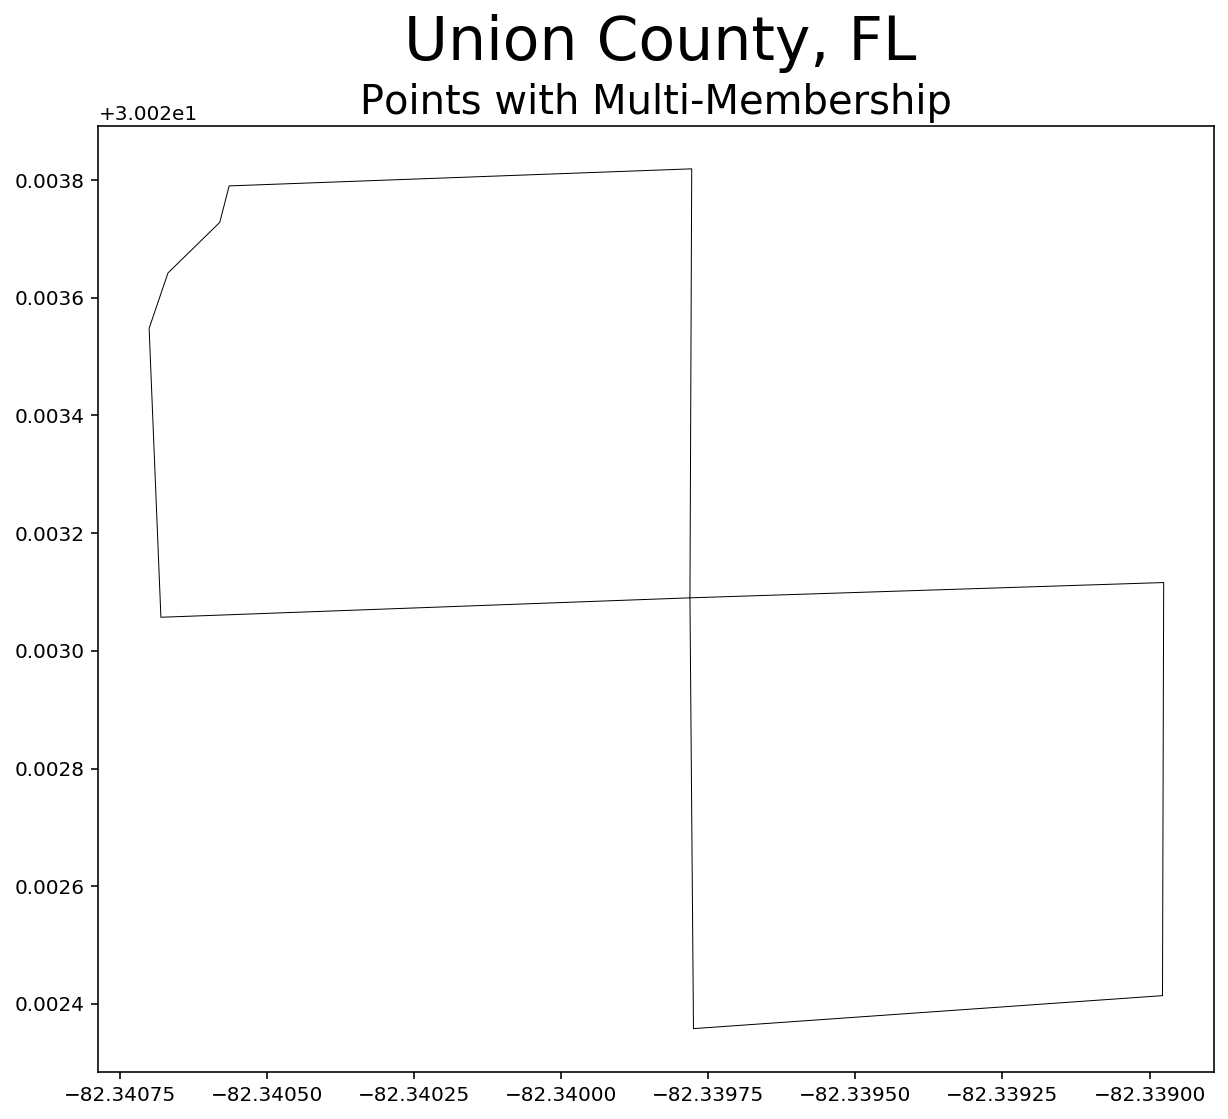

In [18]:
poly_kwargs.update({"lw":.5})
base = rook_blocks.plot(figsize=(10,10.75), **poly_kwargs)
add_suptitle(); add_title("Points with Multi-Membership");

#### Calculate the intersection of the two blocks

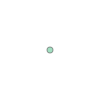

In [19]:
r1, r2 = rook_blocks.geometry[:1].squeeze(), rook_blocks.geometry[1:].squeeze()
intersecting_point = r1.intersection(r2)
intersecting_point

#### Create a point where the two blocks touch

In [20]:
point = geopandas.GeoDataFrame(geometry=[intersecting_point], crs=blocks.crs)
point[ptid] = ["0"]
point

,geometry,ID
0,POINT (-82.33978 30.02309),0


#### Perform the `nd_intersects` method

In [21]:
args = (point, rook_blocks, ptid, pgid, [ptid, pgid])
rook_joined = nd_intersects.nd_intersects(*args)
rook_joined.head()

,ID,GEOID10,geometry
0,0,121259602003040-121259602003042,POINT (-82.33978 30.02309)


#### Plot — Multi-membership

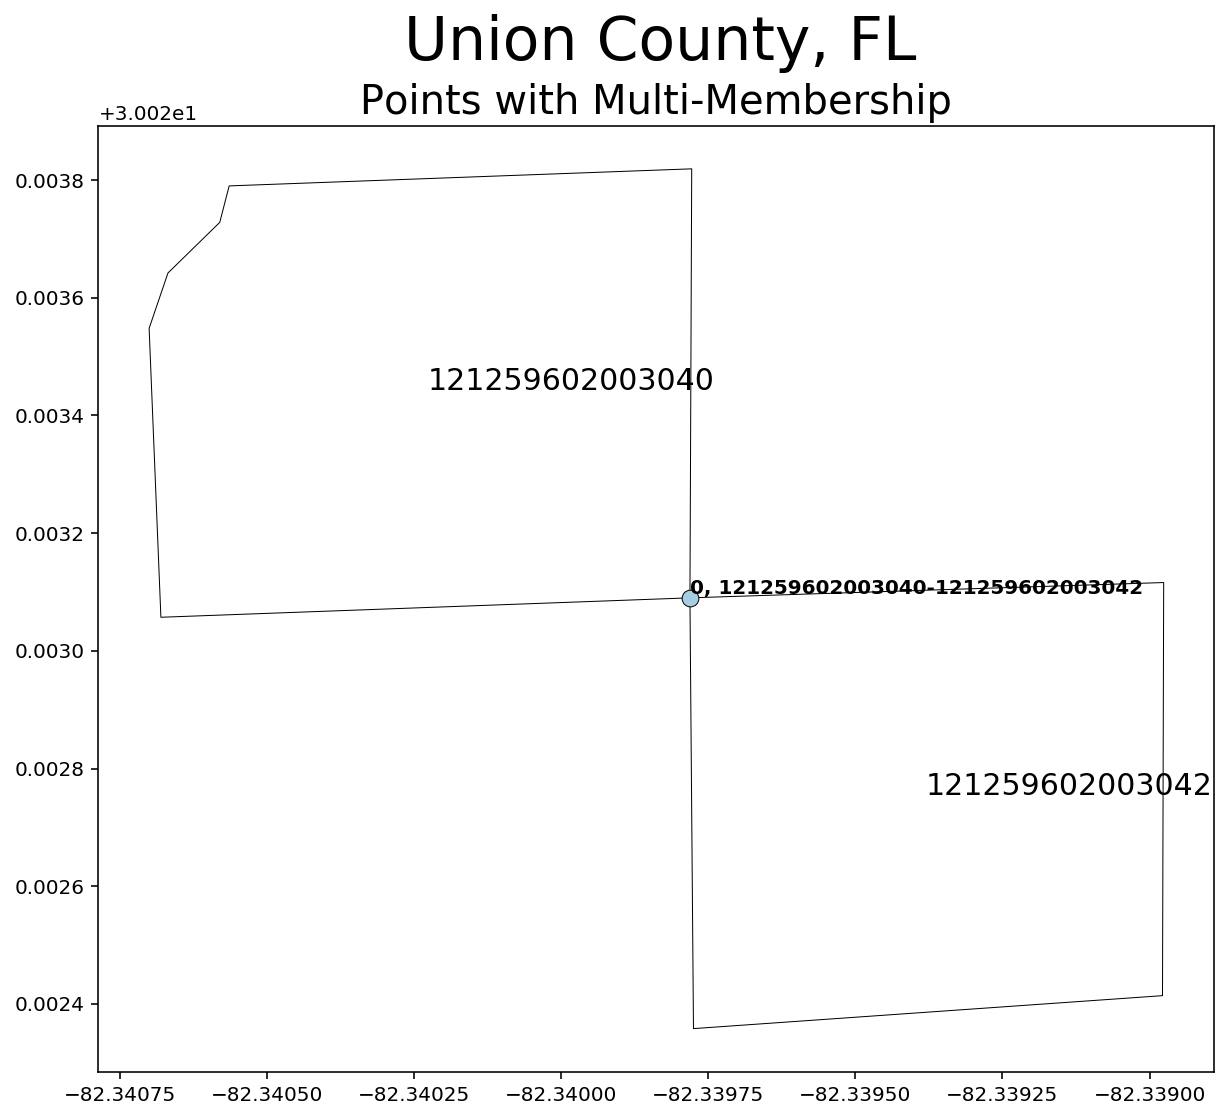

In [22]:
base = rook_blocks.plot(figsize=(10,10.75), **poly_kwargs)
rook_joined.plot(ax=base, **point_kwargs, **join_kwargs)
pgon_labels(rook_blocks)
pt_labels(rook_joined)
add_suptitle(); add_title("Points with Multi-Membership");

------------------------